## Lecture 5: Classification with perceptron model

In [1]:
%matplotlib inline
import os
from tqdm import tqdm
import time
import pickle
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn
from torchvision import datasets
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as function

save_path = './'

In [2]:
with open('../bin/slp/test_features.pckl', 'rb') as f:
	test_features = pickle.load(f)
with open('../bin/slp/test_label.pckl', 'rb') as f:
	test_label = pickle.load(f)
with open('../bin/slp/train_features.pckl', 'rb') as f:
	train_features = pickle.load(f)
with open('../bin/slp/train_label.pckl', 'rb') as f:
	train_label= pickle.load(f)

In [3]:
# Defining a Perceptron

class perceptron(nn.Module):
	def __init__(self, n_channels):
		super(perceptron, self).__init__()
		self.L = nn.Linear(n_channels, 10)
	def forward(self, x):
		x = self.L(x)
		x = function.softmax(x) 
		return x


In [4]:
# Generating 1-hot label encoding
train_label_1hot = np.zeros((50000, 10))
test_label_1hot = np.zeros((10000, 10))
for d1 in range(train_label.shape[0]):
	train_label_1hot[d1, train_label[d1]] = 1
for d2 in range(test_label.shape[0]):
	test_label_1hot[d2, test_label[d2]] = 1

In [5]:
use_gpu = torch.cuda.is_available()
if use_gpu:
	print('GPU is available!')
	pin_mem = True
	device = "cuda"
else :
	print('GPU is not available!')
	pin_mem = False
	device = "cpu"

GPU is available!


In [6]:
# creating TensorDataset
train_dataset = TensorDataset(torch.from_numpy(train_features), torch.from_numpy(train_label_1hot))
test_dataset = TensorDataset(torch.from_numpy(test_features), torch.from_numpy(test_label_1hot))

# creating DataLoader
train_dataloader = DataLoader(train_dataset, num_workers= 4, batch_size= 64, shuffle=True, pin_memory=pin_mem)
test_dataloader = DataLoader(test_dataset, num_workers= 4, batch_size= 64, shuffle=False, pin_memory=pin_mem)

## Defining function for training the network

In [7]:
# defining the training model
def train_model(model, criterion, num_epochs, learning_rate):
	start = time.time()
	train_loss = []
	train_accuracy = []
	temp_labels = []
	for epoch in range(num_epochs):
		epoch_start_time = time.time()
		print('epoch {}/{}' .format(epoch, num_epochs+1))

		running_loss = 0.0
		batch = 0
		for data in tqdm(train_dataloader):
			inputs, labels = data
			inputs, labels = inputs.float().to(device), labels.float().to(device)

			#initializing model gradient to zero
			model.zero_grad()
			# data feed forward through network
			output = model(inputs)
			# predicted class is the one class with maximum probability
			_, prediction = output.data.max(1)
			# finding the Mean Squared Error MSE
			loss = criterion(output, labels)
			# Accumulating loss of each batch
			running_loss += loss.item()

			# backpropogating the error
			if batch == 0:
				total_loss = loss
				total_prediction = prediction
				temp_labels = labels.data.cpu()
				batch+=1
			else:
				total_loss += loss
				total_prediction = torch.cat((torch.Tensor(total_prediction), torch.Tensor(prediction)), 0)
				temp_labels = torch.cat((torch.Tensor(temp_labels), torch.Tensor(labels.data.cpu())), 0)
				batch+=1
			
		total_loss = total_loss/batch
		total_loss.backward(retain_graph=True)

		# for updating the model parameters
		for f in model.parameters():
			f.data.sub_(f.grad.data * learning_rate)

		epoch_loss = running_loss/50000
		train_loss.append(epoch_loss)

		# accuracy per epoch 
		temp_labels = temp_labels.numpy()
		_, total_labels = np.where(temp_labels == 1)
		epoch_accuracy = np.sum(np.equal(total_prediction.cpu().numpy(), np.array(total_labels)))/50000.0
		train_accuracy.append(float(epoch_accuracy*100))

		epoch_time_end = time.time() - epoch_start_time
		print('average epoch loss: {:.6f}'.format(epoch_loss))
		print('average epoch accuracy: {:.6f} %'.format(epoch_accuracy*100))
		print('-' * 25)

		# plotting loss vs epoch
		fig1 = plt.figure(1)
		plt.plot(range(epoch+1),train_loss,'r--',label='train')
		if epoch == 0:
			plt.legend(loc='upper right')
			plt.xlabel('Epoch')
			plt.ylabel('Loss')
			plt.title('plot of training loss vs epoch')
		fig1.savefig(save_path+'loss_plot.png')

		#plotting accuracy vs epoch
		fig2 = plt.figure(2)
		plt.plot(range(epoch+1),train_accuracy,'g--',label='train')
		if epoch == 0:
			plt.legend(loc='upper left')
			plt.xlabel('Epoch')
			plt.ylabel('Accuracy')
			plt.title('plot of training accuracy vs epoch')
		fig2.savefig(save_path+'accuracy_plot.png')
	time_elapsed = time.time() - start
	print('Training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))
	return model

## Training the perceptron

epoch 0/101


  0%|          | 0/782 [00:00<?, ?it/s]/tmp/ipykernel_130548/3771040703.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = function.softmax(x)
100%|██████████| 782/782 [00:00<00:00, 962.40it/s] 


average epoch loss: 0.001415
average epoch accuracy: 8.778000 %
-------------------------
epoch 1/101


100%|██████████| 782/782 [00:00<00:00, 999.43it/s] 


average epoch loss: 0.001415
average epoch accuracy: 8.786000 %
-------------------------
epoch 2/101


100%|██████████| 782/782 [00:00<00:00, 1039.76it/s]


average epoch loss: 0.001415
average epoch accuracy: 8.796000 %
-------------------------
epoch 3/101


100%|██████████| 782/782 [00:00<00:00, 1063.19it/s]


average epoch loss: 0.001415
average epoch accuracy: 8.806000 %
-------------------------
epoch 4/101


100%|██████████| 782/782 [00:00<00:00, 1019.55it/s]


average epoch loss: 0.001415
average epoch accuracy: 8.824000 %
-------------------------
epoch 5/101


100%|██████████| 782/782 [00:00<00:00, 1058.79it/s]


average epoch loss: 0.001415
average epoch accuracy: 8.840000 %
-------------------------
epoch 6/101


100%|██████████| 782/782 [00:00<00:00, 1071.79it/s]


average epoch loss: 0.001415
average epoch accuracy: 8.854000 %
-------------------------
epoch 7/101


100%|██████████| 782/782 [00:00<00:00, 1074.21it/s]


average epoch loss: 0.001415
average epoch accuracy: 8.862000 %
-------------------------
epoch 8/101


100%|██████████| 782/782 [00:00<00:00, 1067.70it/s]


average epoch loss: 0.001415
average epoch accuracy: 8.858000 %
-------------------------
epoch 9/101


100%|██████████| 782/782 [00:00<00:00, 1059.34it/s]


average epoch loss: 0.001414
average epoch accuracy: 8.850000 %
-------------------------
epoch 10/101


100%|██████████| 782/782 [00:00<00:00, 1065.12it/s]


average epoch loss: 0.001414
average epoch accuracy: 8.860000 %
-------------------------
epoch 11/101


100%|██████████| 782/782 [00:00<00:00, 1062.14it/s]


average epoch loss: 0.001414
average epoch accuracy: 8.888000 %
-------------------------
epoch 12/101


100%|██████████| 782/782 [00:00<00:00, 1059.51it/s]


average epoch loss: 0.001414
average epoch accuracy: 8.910000 %
-------------------------
epoch 13/101


100%|██████████| 782/782 [00:00<00:00, 1086.32it/s]


average epoch loss: 0.001414
average epoch accuracy: 8.930000 %
-------------------------
epoch 14/101


100%|██████████| 782/782 [00:00<00:00, 1063.59it/s]


average epoch loss: 0.001414
average epoch accuracy: 8.938000 %
-------------------------
epoch 15/101


100%|██████████| 782/782 [00:00<00:00, 1070.06it/s]


average epoch loss: 0.001414
average epoch accuracy: 8.948000 %
-------------------------
epoch 16/101


100%|██████████| 782/782 [00:00<00:00, 1041.50it/s]


average epoch loss: 0.001414
average epoch accuracy: 8.970000 %
-------------------------
epoch 17/101


100%|██████████| 782/782 [00:00<00:00, 1054.46it/s]


average epoch loss: 0.001414
average epoch accuracy: 8.970000 %
-------------------------
epoch 18/101


100%|██████████| 782/782 [00:00<00:00, 1072.94it/s]


average epoch loss: 0.001414
average epoch accuracy: 8.978000 %
-------------------------
epoch 19/101


100%|██████████| 782/782 [00:00<00:00, 1100.30it/s]


average epoch loss: 0.001414
average epoch accuracy: 8.978000 %
-------------------------
epoch 20/101


100%|██████████| 782/782 [00:00<00:00, 1081.81it/s]


average epoch loss: 0.001413
average epoch accuracy: 8.980000 %
-------------------------
epoch 21/101


100%|██████████| 782/782 [00:00<00:00, 1075.67it/s]


average epoch loss: 0.001413
average epoch accuracy: 8.974000 %
-------------------------
epoch 22/101


100%|██████████| 782/782 [00:00<00:00, 1088.76it/s]


average epoch loss: 0.001413
average epoch accuracy: 8.982000 %
-------------------------
epoch 23/101


100%|██████████| 782/782 [00:00<00:00, 1039.39it/s]


average epoch loss: 0.001413
average epoch accuracy: 8.988000 %
-------------------------
epoch 24/101


100%|██████████| 782/782 [00:00<00:00, 1098.85it/s]


average epoch loss: 0.001413
average epoch accuracy: 9.012000 %
-------------------------
epoch 25/101


100%|██████████| 782/782 [00:00<00:00, 1085.24it/s]


average epoch loss: 0.001413
average epoch accuracy: 9.028000 %
-------------------------
epoch 26/101


100%|██████████| 782/782 [00:00<00:00, 1087.20it/s]


average epoch loss: 0.001413
average epoch accuracy: 9.044000 %
-------------------------
epoch 27/101


100%|██████████| 782/782 [00:00<00:00, 1078.54it/s]


average epoch loss: 0.001413
average epoch accuracy: 9.052000 %
-------------------------
epoch 28/101


100%|██████████| 782/782 [00:00<00:00, 1087.38it/s]


average epoch loss: 0.001413
average epoch accuracy: 9.068000 %
-------------------------
epoch 29/101


100%|██████████| 782/782 [00:00<00:00, 1068.81it/s]


average epoch loss: 0.001413
average epoch accuracy: 9.076000 %
-------------------------
epoch 30/101


100%|██████████| 782/782 [00:00<00:00, 1051.70it/s]


average epoch loss: 0.001413
average epoch accuracy: 9.080000 %
-------------------------
epoch 31/101


100%|██████████| 782/782 [00:00<00:00, 1094.99it/s]


average epoch loss: 0.001413
average epoch accuracy: 9.088000 %
-------------------------
epoch 32/101


100%|██████████| 782/782 [00:00<00:00, 1096.34it/s]


average epoch loss: 0.001413
average epoch accuracy: 9.090000 %
-------------------------
epoch 33/101


100%|██████████| 782/782 [00:00<00:00, 1088.35it/s]


average epoch loss: 0.001412
average epoch accuracy: 9.086000 %
-------------------------
epoch 34/101


100%|██████████| 782/782 [00:00<00:00, 1069.75it/s]


average epoch loss: 0.001412
average epoch accuracy: 9.100000 %
-------------------------
epoch 35/101


100%|██████████| 782/782 [00:00<00:00, 1089.52it/s]


average epoch loss: 0.001412
average epoch accuracy: 9.118000 %
-------------------------
epoch 36/101


100%|██████████| 782/782 [00:00<00:00, 1072.79it/s]


average epoch loss: 0.001412
average epoch accuracy: 9.122000 %
-------------------------
epoch 37/101


100%|██████████| 782/782 [00:00<00:00, 1087.40it/s]


average epoch loss: 0.001412
average epoch accuracy: 9.146000 %
-------------------------
epoch 38/101


100%|██████████| 782/782 [00:00<00:00, 1034.28it/s]


average epoch loss: 0.001412
average epoch accuracy: 9.142000 %
-------------------------
epoch 39/101


100%|██████████| 782/782 [00:00<00:00, 1060.40it/s]


average epoch loss: 0.001412
average epoch accuracy: 9.142000 %
-------------------------
epoch 40/101


100%|██████████| 782/782 [00:00<00:00, 1066.41it/s]


average epoch loss: 0.001412
average epoch accuracy: 9.154000 %
-------------------------
epoch 41/101


100%|██████████| 782/782 [00:00<00:00, 1093.58it/s]


average epoch loss: 0.001412
average epoch accuracy: 9.162000 %
-------------------------
epoch 42/101


100%|██████████| 782/782 [00:00<00:00, 1054.07it/s]


average epoch loss: 0.001412
average epoch accuracy: 9.164000 %
-------------------------
epoch 43/101


100%|██████████| 782/782 [00:00<00:00, 1062.26it/s]


average epoch loss: 0.001412
average epoch accuracy: 9.164000 %
-------------------------
epoch 44/101


100%|██████████| 782/782 [00:00<00:00, 1058.59it/s]


average epoch loss: 0.001412
average epoch accuracy: 9.172000 %
-------------------------
epoch 45/101


100%|██████████| 782/782 [00:00<00:00, 1032.75it/s]


average epoch loss: 0.001412
average epoch accuracy: 9.178000 %
-------------------------
epoch 46/101


100%|██████████| 782/782 [00:00<00:00, 1050.52it/s]


average epoch loss: 0.001412
average epoch accuracy: 9.184000 %
-------------------------
epoch 47/101


100%|██████████| 782/782 [00:00<00:00, 963.08it/s] 


average epoch loss: 0.001412
average epoch accuracy: 9.178000 %
-------------------------
epoch 48/101


100%|██████████| 782/782 [00:00<00:00, 1052.52it/s]


average epoch loss: 0.001412
average epoch accuracy: 9.182000 %
-------------------------
epoch 49/101


100%|██████████| 782/782 [00:00<00:00, 1036.05it/s]


average epoch loss: 0.001411
average epoch accuracy: 9.188000 %
-------------------------
epoch 50/101


100%|██████████| 782/782 [00:00<00:00, 1043.51it/s]


average epoch loss: 0.001411
average epoch accuracy: 9.198000 %
-------------------------
epoch 51/101


100%|██████████| 782/782 [00:00<00:00, 968.40it/s] 


average epoch loss: 0.001411
average epoch accuracy: 9.194000 %
-------------------------
epoch 52/101


100%|██████████| 782/782 [00:00<00:00, 987.82it/s] 


average epoch loss: 0.001411
average epoch accuracy: 9.194000 %
-------------------------
epoch 53/101


100%|██████████| 782/782 [00:00<00:00, 1049.17it/s]


average epoch loss: 0.001411
average epoch accuracy: 9.196000 %
-------------------------
epoch 54/101


100%|██████████| 782/782 [00:00<00:00, 1054.39it/s]


average epoch loss: 0.001411
average epoch accuracy: 9.212000 %
-------------------------
epoch 55/101


100%|██████████| 782/782 [00:00<00:00, 1052.35it/s]


average epoch loss: 0.001411
average epoch accuracy: 9.194000 %
-------------------------
epoch 56/101


100%|██████████| 782/782 [00:00<00:00, 1047.46it/s]


average epoch loss: 0.001411
average epoch accuracy: 9.194000 %
-------------------------
epoch 57/101


100%|██████████| 782/782 [00:00<00:00, 1005.58it/s]


average epoch loss: 0.001411
average epoch accuracy: 9.192000 %
-------------------------
epoch 58/101


100%|██████████| 782/782 [00:00<00:00, 1038.14it/s]


average epoch loss: 0.001411
average epoch accuracy: 9.196000 %
-------------------------
epoch 59/101


100%|██████████| 782/782 [00:00<00:00, 1047.20it/s]


average epoch loss: 0.001411
average epoch accuracy: 9.192000 %
-------------------------
epoch 60/101


100%|██████████| 782/782 [00:00<00:00, 1031.29it/s]


average epoch loss: 0.001411
average epoch accuracy: 9.202000 %
-------------------------
epoch 61/101


100%|██████████| 782/782 [00:01<00:00, 759.01it/s]


average epoch loss: 0.001411
average epoch accuracy: 9.206000 %
-------------------------
epoch 62/101


100%|██████████| 782/782 [00:00<00:00, 841.36it/s]


average epoch loss: 0.001411
average epoch accuracy: 9.216000 %
-------------------------
epoch 63/101


100%|██████████| 782/782 [00:01<00:00, 764.36it/s]


average epoch loss: 0.001411
average epoch accuracy: 9.232000 %
-------------------------
epoch 64/101


100%|██████████| 782/782 [00:00<00:00, 791.42it/s]


average epoch loss: 0.001411
average epoch accuracy: 9.244000 %
-------------------------
epoch 65/101


100%|██████████| 782/782 [00:00<00:00, 794.40it/s]


average epoch loss: 0.001411
average epoch accuracy: 9.256000 %
-------------------------
epoch 66/101


100%|██████████| 782/782 [00:01<00:00, 740.15it/s]


average epoch loss: 0.001411
average epoch accuracy: 9.254000 %
-------------------------
epoch 67/101


100%|██████████| 782/782 [00:00<00:00, 792.94it/s]


average epoch loss: 0.001411
average epoch accuracy: 9.260000 %
-------------------------
epoch 68/101


100%|██████████| 782/782 [00:00<00:00, 789.70it/s]


average epoch loss: 0.001410
average epoch accuracy: 9.256000 %
-------------------------
epoch 69/101


100%|██████████| 782/782 [00:00<00:00, 802.78it/s]


average epoch loss: 0.001410
average epoch accuracy: 9.262000 %
-------------------------
epoch 70/101


100%|██████████| 782/782 [00:01<00:00, 781.42it/s]


average epoch loss: 0.001410
average epoch accuracy: 9.262000 %
-------------------------
epoch 71/101


100%|██████████| 782/782 [00:00<00:00, 793.94it/s]


average epoch loss: 0.001410
average epoch accuracy: 9.268000 %
-------------------------
epoch 72/101


100%|██████████| 782/782 [00:01<00:00, 769.33it/s]


average epoch loss: 0.001410
average epoch accuracy: 9.268000 %
-------------------------
epoch 73/101


100%|██████████| 782/782 [00:00<00:00, 810.00it/s]


average epoch loss: 0.001410
average epoch accuracy: 9.274000 %
-------------------------
epoch 74/101


100%|██████████| 782/782 [00:01<00:00, 777.81it/s]


average epoch loss: 0.001410
average epoch accuracy: 9.274000 %
-------------------------
epoch 75/101


100%|██████████| 782/782 [00:00<00:00, 788.08it/s]


average epoch loss: 0.001410
average epoch accuracy: 9.276000 %
-------------------------
epoch 76/101


100%|██████████| 782/782 [00:00<00:00, 808.65it/s]


average epoch loss: 0.001410
average epoch accuracy: 9.282000 %
-------------------------
epoch 77/101


100%|██████████| 782/782 [00:00<00:00, 792.70it/s]


average epoch loss: 0.001410
average epoch accuracy: 9.290000 %
-------------------------
epoch 78/101


100%|██████████| 782/782 [00:01<00:00, 773.86it/s]


average epoch loss: 0.001410
average epoch accuracy: 9.298000 %
-------------------------
epoch 79/101


100%|██████████| 782/782 [00:00<00:00, 787.01it/s]


average epoch loss: 0.001410
average epoch accuracy: 9.304000 %
-------------------------
epoch 80/101


100%|██████████| 782/782 [00:00<00:00, 810.04it/s]


average epoch loss: 0.001410
average epoch accuracy: 9.302000 %
-------------------------
epoch 81/101


100%|██████████| 782/782 [00:00<00:00, 806.07it/s]


average epoch loss: 0.001410
average epoch accuracy: 9.306000 %
-------------------------
epoch 82/101


100%|██████████| 782/782 [00:00<00:00, 831.44it/s]


average epoch loss: 0.001410
average epoch accuracy: 9.318000 %
-------------------------
epoch 83/101


100%|██████████| 782/782 [00:00<00:00, 1029.32it/s]


average epoch loss: 0.001410
average epoch accuracy: 9.316000 %
-------------------------
epoch 84/101


100%|██████████| 782/782 [00:00<00:00, 993.14it/s] 


average epoch loss: 0.001410
average epoch accuracy: 9.310000 %
-------------------------
epoch 85/101


100%|██████████| 782/782 [00:00<00:00, 1035.56it/s]


average epoch loss: 0.001410
average epoch accuracy: 9.302000 %
-------------------------
epoch 86/101


100%|██████████| 782/782 [00:00<00:00, 1026.26it/s]


average epoch loss: 0.001410
average epoch accuracy: 9.302000 %
-------------------------
epoch 87/101


100%|██████████| 782/782 [00:00<00:00, 992.37it/s] 


average epoch loss: 0.001410
average epoch accuracy: 9.296000 %
-------------------------
epoch 88/101


100%|██████████| 782/782 [00:00<00:00, 970.08it/s] 


average epoch loss: 0.001410
average epoch accuracy: 9.294000 %
-------------------------
epoch 89/101


100%|██████████| 782/782 [00:00<00:00, 941.76it/s] 


average epoch loss: 0.001410
average epoch accuracy: 9.298000 %
-------------------------
epoch 90/101


100%|██████████| 782/782 [00:00<00:00, 971.57it/s] 


average epoch loss: 0.001410
average epoch accuracy: 9.304000 %
-------------------------
epoch 91/101


100%|██████████| 782/782 [00:00<00:00, 952.82it/s] 


average epoch loss: 0.001410
average epoch accuracy: 9.296000 %
-------------------------
epoch 92/101


100%|██████████| 782/782 [00:00<00:00, 1026.26it/s]


average epoch loss: 0.001410
average epoch accuracy: 9.296000 %
-------------------------
epoch 93/101


100%|██████████| 782/782 [00:00<00:00, 1033.56it/s]


average epoch loss: 0.001409
average epoch accuracy: 9.294000 %
-------------------------
epoch 94/101


100%|██████████| 782/782 [00:00<00:00, 1020.27it/s]


average epoch loss: 0.001409
average epoch accuracy: 9.298000 %
-------------------------
epoch 95/101


100%|██████████| 782/782 [00:00<00:00, 1040.82it/s]


average epoch loss: 0.001409
average epoch accuracy: 9.300000 %
-------------------------
epoch 96/101


100%|██████████| 782/782 [00:00<00:00, 973.11it/s] 


average epoch loss: 0.001409
average epoch accuracy: 9.300000 %
-------------------------
epoch 97/101


100%|██████████| 782/782 [00:00<00:00, 969.12it/s] 


average epoch loss: 0.001409
average epoch accuracy: 9.294000 %
-------------------------
epoch 98/101


100%|██████████| 782/782 [00:00<00:00, 929.27it/s] 


average epoch loss: 0.001409
average epoch accuracy: 9.284000 %
-------------------------
epoch 99/101


100%|██████████| 782/782 [00:00<00:00, 992.73it/s] 


average epoch loss: 0.001409
average epoch accuracy: 9.280000 %
-------------------------
Training complete in 1m 34s


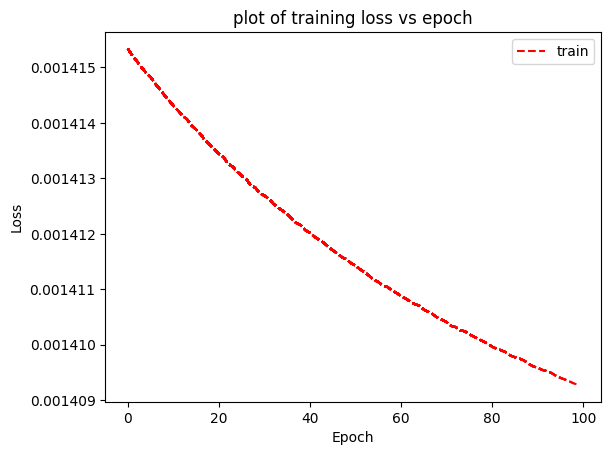

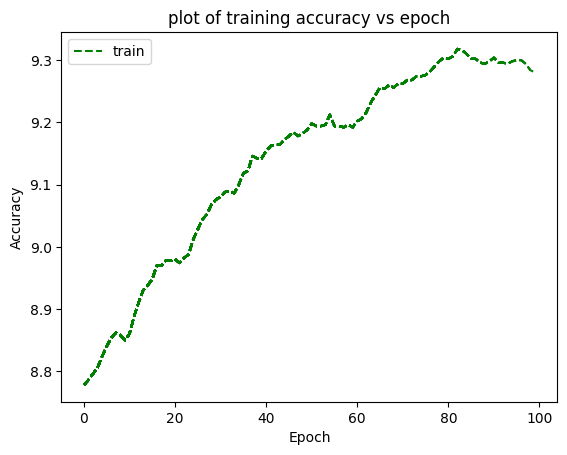

In [8]:
featLength = 2+5+2
# Initilaizing the model
model = perceptron(featLength).to(device)
criterion = nn.MSELoss() 
model = train_model(model,criterion,num_epochs=100,learning_rate=1) # Training the model